In [1]:
import os
import pickle
import scipy
import math

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tsfresh as tsf

from tqdm import tqdm
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Dropout, BatchNormalization, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
from collections import OrderedDict
from scipy import stats
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, Dense, Add 
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler 

### 0.3 Constants

In [2]:
FEATURES = ["altitude", "groundspeed", "vertical_rate", "x", "y"]
DIFF_FEATURES = ["altitude", "groundspeed", "x", "y"]
STATE_VECTOR_FEATURES = ["groundspeed", "vertical_rate", "longitude", "latitude", "altitude", "heading_unwrapped"]

MODEL_DIR = "models"
MODEL_DIR = os.path.join(MODEL_DIR, "standard")
MODEL_LSTM_DIR = os.path.join(MODEL_DIR, "lstm")

DATA_DIR = "data"
DATA_TRAIN_DIR = os.path.join(DATA_DIR, "train")
DATA_VALIDATION_DIR = os.path.join(DATA_DIR, "validation")
DATA_TEST_DIR = os.path.join(DATA_DIR, "test")
DATA_TEST_DEPARTING_DIR = os.path.join(DATA_TEST_DIR, "departing")
DATA_TEST_LANDING_DIR = os.path.join(DATA_TEST_DIR, "landing")
DATA_TEST_MANOEUVER_DIR = os.path.join(DATA_TEST_DIR, "manoeuver")
DATA_TEST_NOISE_DIR = os.path.join(DATA_TEST_DIR, "noise")
DATA_TEST_STAND_DIR = os.path.join(DATA_TEST_DIR, "stand")
DATA_TEST_DEVIATION_DIR = os.path.join(DATA_TEST_DIR, "deviation")


########################################
#             DIFFERENCING             #
########################################

DIFF_DATA = True

########################################
#        SYSTEM HYPERPARAMETERS        #
########################################

K_LAG = 1
K_ORDER = 1
WINDOW_SIZE_transformer = WINDOW_SIZE_LSTM_transformer = 60
transformer_ENCODING_DIMENSION = 10
LSTM_transformer_ENCODING_DIMENSION = 10
Q_THRESHOLD = 10e-4
LSTM_Q_THRESHOLD = 10e-2

## 1. Util Functions

In [3]:
 def rolled(list_, window_size):

    count = 0
    while count <= len(list_) - window_size:
        yield list_[count: count + window_size]
        count += 1  
  
def max_rolled(list_, window_size):  
    y = []  
    for val in rolled(list_, window_size):  
        y.append(max(val))  
    return np.array(y)  
  
def get_windows_data(df, labels, window_size, tsfresh=True):   
      
    collected_data = []  
      
    for i, val in enumerate(rolled(df.values, window_size)):  
        if tsfresh:  
            val_with_id_time = pd.DataFrame(val, columns=df.columns)  
            val_with_id_time["id"] = i  
            val_with_id_time["time"] = list(range(val.shape[0]))  
            collected_data.append(val_with_id_time)  
        else:  
            collected_data.append(val)  
      
    # 合并数据  
    if tsfresh:  
        X = pd.concat(collected_data, ignore_index=True)  
    else:  
        X = np.array(collected_data)  
      
    # 计算y值  
    y = max_rolled(labels, window_size)  
      
    return X, y  


In [4]:
def diff_data(df, cols, lag, order):
  """
  apply time series differrencing to the data
  :param df: dataframe
  :param cols: columns to apply differencing
  :param lag: k-lag
  :param order: k-order
  :return: df_diff - dataframe with differencing 
  """
  assert lag > 0
  assert order > 0

  df_diff = df[cols]

  for i in range(order):
      df_diff = df_diff.diff(periods=lag)

      # remove NAN value rows from df_diff
      df_diff = df_diff[lag:]

  # return excluded columns
  excluded_cols = [x for x in df.columns if x not in cols]

  for col in excluded_cols:
    df_diff[col] = df[col][lag * order:]

  return df_diff

In [5]:
def filter_outliers(df, std=5, cols=None):
  """
  remove extreme outliers in data 
  :param df: data (data frame)
  :param std: amount of standard deviation (remove values withe larger values)
  :param df: columns to apply
  :return: filtered data frame
  """
  selected_cols = df.columns if cols is None else cols

  return df[(np.abs(stats.zscore(df[selected_cols])) < std).all(axis=1)]

In [6]:
def get_average_detection_delay(y_true, y_pred):
  """
  return average detection delay for labels and predections
  :param y_true: labels
  :param y_pred: predections
  :return: average detection delay
  """
  assert len(y_true) == len(y_pred)

  in_window = False
  detected_in_window = False
  detection_delay_sum = 0
  windows_count = 0

  for i in range(len(y_true) - 1):
    curr_true = y_true[i]
    next_true = y_true[i + 1]
    curr_pred = y_pred[i]

    if in_window and not detected_in_window:
      if curr_pred == 1:
        detected_in_window = True
      else:
        detection_delay_sum += 1

    if (curr_true == 0 and next_true == 1) or (curr_true == 1 and i == 0):
      in_window = True
      windows_count += 1

    if curr_true == 1 and next_true == 0:
      in_window = False
      detected_in_window = False

  # window is not padded
  if next_true == 1:
    detection_delay_sum += 1

  # window is not padded
  if y_true[0] == 1:
    detection_delay_sum += 1

  return detection_delay_sum / windows_count if windows_count > 0 else 0

In [7]:
def classification_report(y_true_l, **kwargs):
  """
  classification report with benchmark results (input classifier names and predictions)
  :param y_true: labels list (should be same lenght as detectors in kwargs)
  :return: filtered data frame
  """
  detector_dict = OrderedDict()
  detector_dict["Perfect Detector"] = y_true_l[0], y_true_l[0]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)
    detector_dict[key] = value, y_true_l[i]

  detector_dict["Null Detector 1"] = [0] * len(y_true_l[0]), y_true_l[0]
  detector_dict["Null Detector 2"] = [1] * len(y_true_l[0]), y_true_l[0]

  np.random.seed(0)
  detector_dict["Random Detector"] = np.where(np.random.rand(len(y_true_l[0])) >= 0.5, 1, 0), y_true_l[0]

  data = []

  for key, value in detector_dict.items():
    data.append(
        [
         key,
         round(precision_score(value[1], value[0]), 3),
         round(recall_score(value[1], value[0]), 3),
         round(get_average_detection_delay(value[1], value[0]), 3)
        ]
    )
  
  return pd.DataFrame(columns=["Detector", "Precision", "TPR", "Average Detection Delay"], data=data)

In [8]:
def roc_fig_plot(y_true_l, **kwargs):
  """
  plot roc curves (input classifier names and scores)
  :param y_true_l: labels list (should be same lenght as detectors in kwargs)
  :return: 
  """
  plt.rcParams["figure.figsize"] = (10, 10)
  styles = ["-", "--"]
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)

    style = styles[i % 2]
    color_idx = math.floor(i / 2)
    color = colors[color_idx % (len(colors) - 1)]

    fpr, tpr, threshold = roc_curve(y_true_l[i], value)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, style, label=f'AUC {key.replace("_", " ")} = {round(roc_auc, 3)}', color=color)

  plt.title('Receiver Operating Characteristic')
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('TPR')
  plt.xlabel('FPR')
  plt.show()

In [9]:
def precision_recall_fig_plot(y_true_l, **kwargs):
  """
  plot precision recall curve (input classifier names and scores)
  :param y_true_l: labels list (should be same lenght as detectors in kwargs)
  :return: 
  """
  plt.rcParams["figure.figsize"] = (10, 10)
  styles = ["-", "--"]
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)

    style = styles[i % 2]
    color_idx = math.floor(i / 2) 
    color = colors[color_idx % (len(colors) - 1)]

    precision, recall, thresholds = precision_recall_curve(y_true_l[i], value)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, style, label=f'AUC {key.replace("_", " ")} = {round(prc_auc, 3)}', color=color)

  plt.title('Precision Recall Curve')
  plt.legend(loc = 'lower right')
  plt.xlim([0.1, 1])
  plt.ylim([0, 1])
  plt.ylabel('precision')
  plt.xlabel('recall')
  plt.show()

In [10]:
def anomaly_score(score, mu, sig):
  """
  anomaly scores based on CDF func
  :param score: list of scores given by model
  :param mu: mean of normal dist
  :param sig: std of normal dist
  :return: anomaly scores
  """
  return 1 - stats.norm.sf(score, mu, sig)

In [11]:
def q_verdict(x, mu, sig, n=0.1):
  """
  verdict based on CDF func
  :param score: list of scores given by model
  :param mu: mean of normal dist
  :param sig: std of normal dist
  :param n: threshold (hyperparameter)
  :return: verdicts
  """
  return np.where(anomaly_score(x, mu, sig) >= 1 - n, 1, 0)

In [12]:
def test_noraml_dist(x, alpha=0.05):
  """
  Perform the Shapiro-Wilk test for normality

  :param x: The array containing the sample to be tested
  :param alpha: threshold for rejection of null hypothesis
  """
  # For N > 5000 the W test statistic is accurate but the p-value may not be.
  # The chance of rejecting the null hypothesis when it is true is close to 5% regardless of sample size.
  length = min(len(x), 2500)
  stats, p = scipy.stats.shapiro(x[:length])
  print(f"p-value: {p}")
  if p < alpha:  # null hypothesis: the data was drawn from a normal distribution
      print("The null hypothesis can be rejected")
  else:
      print("The null hypothesis cannot be rejected")


## 2. Load Data

### 2.2 Real Data

In [13]:
data_dict = {
    "train": [],
    "validation": [],
    "test_noise": [],
    "test_landing": [],
    "test_departing": [],
    "test_manoeuver": [],
    "test_deviation":[],
    "test_stand": [],
}

In [14]:
paths = {
    "train": DATA_TRAIN_DIR,
    "validation": DATA_VALIDATION_DIR,
    "test_noise": DATA_TEST_NOISE_DIR,
    "test_landing": DATA_TEST_LANDING_DIR,
    "test_departing": DATA_TEST_DEPARTING_DIR,
    "test_manoeuver": DATA_TEST_MANOEUVER_DIR,
    "test_deviation": DATA_TEST_DEVIATION_DIR,
    "test_stand": DATA_TEST_STAND_DIR,
}

In [15]:
for key, path in paths.items():
  files = os.listdir(path)

  for file in files:
    df = pd.read_csv(os.path.join(path, file))
    if key == "train":
      df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=5)
    if key == "validation":
      df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=8)

    if DIFF_DATA:
      df = diff_data(df, cols=DIFF_FEATURES, lag=K_LAG, order=K_ORDER)
    
    data_dict[key].append(df)

In [26]:
file

'VIR63.csv'

## 3. transformer

In [106]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [107]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [108]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions 

In [109]:
vocab_size = 50000  # Only consider the top 20k words
maxlen = 50  # Only consider the first 200 words of each movie review
embed_dim = 32  # Embedding size for each token6
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(50, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddi  (None, 50, 32)            1601600   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 50, 32)            6464      
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [17]:
transformer_model_feature_pipeline = Pipeline(
    steps=[('scaler', MinMaxScaler(feature_range=(0.01, 1)))]
)

### 3.1 Train

In [18]:
X_l = []
y_l = []

for df in tqdm(data_dict["train"]):
  X, y = get_windows_data(df[FEATURES], [0] * df.shape[0], window_size=WINDOW_SIZE_transformer, tsfresh=True)
  X_l.append(X)
  y_l.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03s/it]


In [19]:
# 收集所有处理后的DataFrame  
X_train_list = []  
  
# 初始化y_train为列表，因为我们可以直接扩展列表  
y_train = []  
  
for i in tqdm(range(len(X_l))):  
    try:  
        # 提取特征并处理DataFrame  
        X_temp = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))  
        X_train_list.append(X_temp)  
  
        # 假设y_l[i]已经是NumPy数组或者可以转换为NumPy数组  
        y_train.extend(y_l[i])  # 使用extend来扩展列表  
  
    except Exception as e:  
        print(e)  
        continue  
  
# 使用pd.concat连接所有的DataFrame  
X_train = pd.concat(X_train_list, ignore_index=True)  
  
# 将y_train转换为NumPy数组（如果它还不是）  
y_train = np.array(y_train)  
  
# 断言检查X_train和y_train的长度是否相等  
assert len(X_train) == len(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:42<00:00,  4.88s/it]


In [20]:
X_train.head()

,altitude__sum_values,altitude__median,altitude__mean,altitude__length,altitude__standard_deviation,altitude__variance,altitude__root_mean_square,altitude__maximum,altitude__absolute_maximum,altitude__minimum,...,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum
0,25.000000,0.0,0.416667,60.0,3.810060,14.516560,3.832776,25.0,25.0,-1.923077,...,1077.305907,17.314034,17.955098,60.0,5.031956,25.320583,18.646880,36.059727,36.059727,6.266093
1,16.666667,0.0,0.277778,60.0,3.668188,13.455603,3.678690,25.0,25.0,-1.923077,...,1066.889846,17.314034,17.781497,60.0,4.833882,23.366419,18.426830,36.059727,36.059727,6.266093
2,8.333333,0.0,0.138889,60.0,3.515120,12.356066,3.517862,25.0,25.0,-1.923077,...,1056.483108,17.314034,17.608052,60.0,4.620843,21.352189,18.204276,36.059727,36.059727,6.266093
3,0.000000,0.0,0.000000,60.0,3.349321,11.217949,3.349321,25.0,25.0,-1.923077,...,1048.029497,17.314034,17.467158,60.0,4.404147,19.396513,18.013832,36.059727,36.059727,6.266093
4,0.000000,0.0,0.000000,60.0,3.349321,11.217949,3.349321,25.0,25.0,-1.923077,...,1052.753726,17.322465,17.545895,60.0,4.411214,19.458812,18.091911,36.059727,36.059727,6.266093


In [21]:
X_train_n = transformer_model_feature_pipeline.fit_transform(X_train)
X_train_n

array([[0.50676786, 0.42939481, 0.50676786, ..., 0.27077391, 0.01134121,
        0.98440845],
       [0.50617857, 0.42939481, 0.50617857, ..., 0.27077391, 0.01134121,
        0.98440845],
       [0.50558929, 0.42939481, 0.50558929, ..., 0.27077391, 0.01134121,
        0.98440845],
       ...,
       [0.50323214, 0.42939481, 0.50323214, ..., 0.50393952, 0.02119863,
        0.98417911],
       [0.50323214, 0.42939481, 0.50323214, ..., 0.50393952, 0.02119863,
        0.98417911],
       [0.50323214, 0.42939481, 0.50323214, ..., 0.50393952, 0.02119863,
        0.98417911]])

In [22]:
logs = "logs/transformer/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = [500,520])

In [23]:
X_train_n.shape

(69263, 50)

In [110]:
model.compile(loss='mse', optimizer='adam')

In [111]:
history = model.fit(X_train_n, X_train_n,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    callbacks=[tboard_callback]).history

Epoch 1/10
2165/2165 [==============================] - 26s 11ms/step - loss: 0.0089
Epoch 2/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0042
Epoch 3/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0040
Epoch 4/10
2165/2165 [==============================] - 25s 11ms/step - loss: 0.0039
Epoch 5/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0038
Epoch 6/10
2165/2165 [==============================] - 23s 11ms/step - loss: 0.0037
Epoch 7/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0037
Epoch 8/10
2165/2165 [==============================] - 25s 11ms/step - loss: 0.0037
Epoch 9/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0037
Epoch 10/10
2165/2165 [==============================] - 24s 11ms/step - loss: 0.0037


### 3.2 Validation

In [26]:
X_l = []
y_l = []

for df in tqdm(data_dict["validation"]):
  X, y = get_windows_data(df[FEATURES], [0] * df.shape[0], window_size=WINDOW_SIZE_transformer, tsfresh=True)
  X_l.append(X)
  y_l.append(y)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


In [27]:
assert len(X_l) == len(y_l)

y_val = np.array([])
first = True

for i in tqdm(range(len(X_l))):
  try:
    if first:
      X_val = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))
      first = False
    else:
      X_val = X_val.append(impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters())), ignore_index=True)

    y_val = np.append(y_val, y_l[i])
  except:
    continue

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]


In [28]:
X_val_n = transformer_model_feature_pipeline.transform(X_val)

In [112]:
preds_val = model.predict(X_val_n)

267/267 [==============================] - 1s 2ms/step


In [113]:
reconstruction_errors = []

for i, row in enumerate(X_val_n):
  reconstruction_errors.append(np.linalg.norm(X_val_n[i] - preds_val[i]) ** 2)

reconstruction_errors_df = pd.DataFrame(columns=["reconstruction_errors"], data=reconstruction_errors)

In [114]:
reconstruction_errors_df.describe()

,reconstruction_errors
count,8530.000000
mean,0.029970
std,0.063123
min,0.005341
25%,0.011767
50%,0.011767
75%,0.011767
max,0.593256


In [115]:
test_noraml_dist(reconstruction_errors_df.values)

p-value: 3.798293837934747e-61
The null hypothesis can be rejected


In [116]:
mu = np.mean(reconstruction_errors_df["reconstruction_errors"].values)
mu

0.02997043883503327

In [117]:
std = np.std(reconstruction_errors_df["reconstruction_errors"].values)
std

0.06311930869224804

### 3.3 Test

In [35]:
keys = [x for x in data_dict.keys() if x.startswith("test_")]
keys

['test_noise',
 'test_landing',
 'test_departing',
 'test_manoeuver',
 'test_deviation',
 'test_stand']

In [36]:
X_t_l = []
y_t_l = []

for key in tqdm(keys):
  X_l = []
  y_l = []
  for df in tqdm(data_dict[key]):
    X, y = get_windows_data(df[FEATURES], df["anomaly"], window_size=WINDOW_SIZE_transformer, tsfresh=True)
    X_l.append(X)
    y_l.append(y)

  X_t_l.append(X_l)
  y_t_l.append(y_l)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.97s/it]


In [37]:
X_t_test = []
y_t_test = []

for i in tqdm(range(len(keys))):
  X_l = X_t_l[i]
  y_l = y_t_l[i]

  assert len(X_l) == len(y_l)

  y_test = np.array([])
  first = True

  for i in tqdm(range(len(X_l))):
    try:
      if first:
        X_test = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))
        first = False
      else:
        val = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))
        X_test = X_test.append(val, ignore_index=True)

      y_test = np.append(y_test, y_l[i])
    except Exception as e:
      print(e)
      continue

  X_t_test.append(X_test)
  y_t_test.append(y_test)    

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.68s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:14,  2.37it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:02<00:06,  4.85it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.24it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02,  9.43it/s]

Feature Extraction:  50%|███████████████████████████████                               | 20/40 [00:03<00:01, 12.88it/s]

Feature Extraction:  60%|███████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:43,  2.66s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.41it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:02<00:03,  7.18it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:02<00:02, 10.92it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 15.26it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 21.03it/s]

Feature Extraction:  85%|████████████████████████████████████████████████████▋         | 34/40 [00:03<00:00, 20.51it/s]

Feature Extraction: 100%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.68s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:11,  2.86it/s]

Feature Extraction:  28%|█████████████████                                             | 11/40 [00:02<00:04,  5.92it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02,  9.56it/s]

Feature Extraction:  50%|███████████████████████████████                               | 20/40 [00:03<00:01, 10.78it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:01, 14.96it/s]

Feature Extraction:  75%|██████████████████████████████████████████████▌               | 30/40 [00:03<00:00, 19.31it/s]

Feature Extraction:  85%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.71s/it]

Feature Extraction:   5%|███▏                                                           | 2/40 [00:02<00:47,  1.24s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:03<00:10,  3.26it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:03<00:04,  6.24it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:02,  9.51it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:01, 13.04it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 16.86it/s]

Feature Extraction:  65%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.67s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:10,  3.14it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.07it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.35it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 15.21it/s]

Feature Extraction:  75%|██████████████████████████████████████████████▌               | 30/40 [00:03<00:00, 20.45it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.16it/s]

 86%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:51,  2.85s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:15,  2.22it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:03<00:06,  4.60it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:03,  7.42it/s]

Feature Extraction:  42%|██████████████████████████▎                                   | 17/40 [00:03<00:02, 10.63it/s]

Feature Extraction:  52%|████████████████████████████████▌                             | 21/40 [00:03<00:01, 14.16it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:01, 13.97it/s]

Feature Extraction:  72%|█████

'DataFrame' object has no attribute 'append'



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.70s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.62it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:03<00:06,  4.86it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  7.60it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.72it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 14.15it/s]

Feature Extraction:  65%|██████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:43,  2.66s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.40it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:02<00:03,  7.14it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.56it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 13.55it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 17.45it/s]

Feature Extraction:  85%|████████████████████████████████████████████████████▋         | 34/40 [00:03<00:00, 21.98it/s]

Feature Extraction: 100%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.70s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:11,  2.84it/s]

Feature Extraction:  28%|█████████████████                                             | 11/40 [00:02<00:04,  5.93it/s]

Feature Extraction:  38%|███████████████████████▎                                      | 15/40 [00:03<00:03,  7.68it/s]

Feature Extraction:  50%|███████████████████████████████                               | 20/40 [00:03<00:01, 11.54it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 14.66it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 19.56it/s]

Feature Extraction:  82%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:51,  2.85s/it]

Feature Extraction:   8%|████▋                                                          | 3/40 [00:02<00:28,  1.28it/s]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:03<00:08,  3.72it/s]

Feature Extraction:  28%|█████████████████                                             | 11/40 [00:03<00:04,  6.60it/s]

Feature Extraction:  38%|███████████████████████▎                                      | 15/40 [00:03<00:02,  9.95it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 13.44it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 13.35it/s]

Feature Extraction:  68%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:43,  2.67s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.39it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:02<00:03,  7.11it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.81it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:00, 16.05it/s]

Feature Extraction:  75%|██████████████████████████████████████████████▌               | 30/40 [00:03<00:00, 21.36it/s]

Feature Extraction:  88%|██████████████████████████████████████████████████████▎       | 35/40 [00:03<00:00, 20.83it/s]

Feature Extraction: 100%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.72s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.82it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.20it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  8.07it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:01, 11.36it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 12.06it/s]

Feature Extraction:  65%|████████████████████████████████████████▎                     | 26/40 [00:03<00:00, 15.62it/s]

Feature Extraction:  75%|█████

'DataFrame' object has no attribute 'append'



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.71s/it]

Feature Extraction:   5%|███▏                                                           | 2/40 [00:02<00:46,  1.23s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:03<00:10,  3.28it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:03<00:04,  6.29it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:02,  9.67it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:01, 13.38it/s]

Feature Extraction:  55%|██████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.69s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:11,  2.86it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:02<00:04,  6.64it/s]

Feature Extraction:  42%|██████████████████████████▎                                   | 17/40 [00:03<00:02,  9.02it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 13.84it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 19.06it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.01it/s]

 43%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.69s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:14,  2.36it/s]

Feature Extraction:  20%|████████████▌                                                  | 8/40 [00:03<00:08,  3.89it/s]

Feature Extraction:  28%|█████████████████                                             | 11/40 [00:03<00:04,  5.98it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02, 10.29it/s]

Feature Extraction:  52%|████████████████████████████████▌                             | 21/40 [00:03<00:01, 14.93it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:00, 18.66it/s]

Feature Extraction:  72%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.68s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:14,  2.37it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:02<00:06,  4.83it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:03,  7.71it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02,  8.84it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.08it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 14.65it/s]

Feature Extraction:  68%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.69s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.36it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:02<00:03,  7.13it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.55it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 15.70it/s]

Feature Extraction:  75%|██████████████████████████████████████████████▌               | 30/40 [00:03<00:00, 21.13it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.12it/s]

 86%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.71s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.83it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.28it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  8.15it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02,  9.97it/s]

Feature Extraction:  52%|████████████████████████████████▌                             | 21/40 [00:03<00:01, 12.07it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:00, 15.90it/s]

Feature Extraction:  72%|█████

'DataFrame' object has no attribute 'append'



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:52,  2.89s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:03<00:15,  2.20it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:03<00:06,  4.56it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:03,  7.44it/s]

Feature Extraction:  42%|██████████████████████████▎                                   | 17/40 [00:03<00:02, 10.66it/s]

Feature Extraction:  52%|████████████████████████████████▌                             | 21/40 [00:03<00:01, 14.27it/s]

Feature Extraction:  62%|██████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:46,  2.72s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.33it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:02<00:04,  6.42it/s]

Feature Extraction:  42%|██████████████████████████▎                                   | 17/40 [00:03<00:02,  9.00it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 12.86it/s]

Feature Extraction:  70%|███████████████████████████████████████████▍                  | 28/40 [00:03<00:00, 18.20it/s]

Feature Extraction:  85%|████████████████████████████████████████████████████▋         | 34/40 [00:03<00:00, 23.62it/s]

Feature Extraction: 100%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.69s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:11,  2.85it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:03<00:07,  4.23it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  7.71it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.92it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 14.53it/s]

Feature Extraction:  65%|████████████████████████████████████████▎                     | 26/40 [00:03<00:00, 18.35it/s]

Feature Extraction:  78%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.69s/it]

Feature Extraction:  10%|██████▎                                                        | 4/40 [00:02<00:19,  1.86it/s]

Feature Extraction:  20%|████████████▌                                                  | 8/40 [00:02<00:07,  4.37it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:03,  7.29it/s]

Feature Extraction:  38%|███████████████████████▎                                      | 15/40 [00:03<00:02,  8.62it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.74it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 14.48it/s]

Feature Extraction:  65%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.69s/it]

Feature Extraction:  20%|████████████▌                                                  | 8/40 [00:02<00:08,  3.85it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:02<00:03,  7.52it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.14it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 13.05it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 17.28it/s]

Feature Extraction:  85%|████████████████████████████████████████████████████▋         | 34/40 [00:03<00:00, 21.81it/s]

Feature Extraction: 100%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:46,  2.73s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:15,  2.32it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:02<00:06,  4.78it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.12it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02,  9.27it/s]

Feature Extraction:  50%|███████████████████████████████                               | 20/40 [00:03<00:01, 12.96it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:00, 16.56it/s]

Feature Extraction:  70%|█████

'DataFrame' object has no attribute 'append'



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.69s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:11,  2.84it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.27it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  8.18it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:01, 11.50it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 12.26it/s]

Feature Extraction:  65%|██████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.72s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.62it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.10it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.31it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 15.11it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 19.41it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.96it/s]

 43%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:52,  2.88s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.67it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:03<00:05,  5.01it/s]

Feature Extraction:  38%|███████████████████████▎                                      | 15/40 [00:03<00:02,  8.53it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.72it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:00, 16.10it/s]

Feature Extraction:  70%|███████████████████████████████████████████▍                  | 28/40 [00:03<00:00, 15.68it/s]

Feature Extraction:  80%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.70s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:14,  2.36it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:02<00:06,  4.81it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.28it/s]

Feature Extraction:  38%|███████████████████████▎                                      | 15/40 [00:03<00:02,  8.46it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.99it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 15.44it/s]

Feature Extraction:  68%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.69s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:09,  3.36it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:02<00:03,  7.10it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 11.52it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 13.50it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 17.47it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.10it/s]

 86%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:46,  2.72s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.81it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.25it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  7.02it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 10.90it/s]

Feature Extraction:  57%|███████████████████████████████████▋                          | 23/40 [00:03<00:01, 13.98it/s]

Feature Extraction:  68%|█████████████████████████████████████████▊                    | 27/40 [00:03<00:00, 17.60it/s]

Feature Extraction:  78%|█████

'DataFrame' object has no attribute 'append'



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.71s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.83it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.28it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  8.15it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:01, 11.45it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 12.06it/s]

Feature Extraction:  65%|██████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:44,  2.69s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:10,  3.10it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:04,  6.58it/s]

Feature Extraction:  48%|█████████████████████████████▍                                | 19/40 [00:03<00:01, 10.74it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:00, 15.59it/s]

Feature Extraction:  78%|████████████████████████████████████████████████              | 31/40 [00:03<00:00, 20.89it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 11.15it/s]

 43%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.70s/it]

Feature Extraction:   5%|███▏                                                           | 2/40 [00:02<00:46,  1.24s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:03<00:08,  3.94it/s]

Feature Extraction:  28%|█████████████████                                             | 11/40 [00:03<00:04,  6.93it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02, 11.34it/s]

Feature Extraction:  50%|███████████████████████████████                               | 20/40 [00:03<00:01, 14.98it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:00, 19.71it/s]

Feature Extraction:  72%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:45,  2.71s/it]

Feature Extraction:  12%|███████▉                                                       | 5/40 [00:02<00:15,  2.33it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:02<00:06,  4.74it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:04,  6.68it/s]

Feature Extraction:  40%|████████████████████████▊                                     | 16/40 [00:03<00:02,  8.80it/s]

Feature Extraction:  52%|████████████████████████████████▌                             | 21/40 [00:03<00:01, 13.20it/s]

Feature Extraction:  62%|██████████████████████████████████████▊                       | 25/40 [00:03<00:00, 16.51it/s]

Feature Extraction:  72%|█████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:49,  2.82s/it]

Feature Extraction:  18%|███████████                                                    | 7/40 [00:02<00:10,  3.22it/s]

Feature Extraction:  30%|██████████████████▌                                           | 12/40 [00:03<00:04,  6.20it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.55it/s]

Feature Extraction:  60%|█████████████████████████████████████▏                        | 24/40 [00:03<00:01, 15.57it/s]

Feature Extraction:  72%|████████████████████████████████████████████▉                 | 29/40 [00:03<00:00, 16.40it/s]

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.69it/s]

 86%|█████████████████████████

'DataFrame' object has no attribute 'append'




Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:02<01:46,  2.72s/it]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:02<00:12,  2.81it/s]

Feature Extraction:  25%|███████████████▌                                              | 10/40 [00:02<00:05,  5.25it/s]

Feature Extraction:  35%|█████████████████████▋                                        | 14/40 [00:03<00:03,  7.06it/s]

Feature Extraction:  45%|███████████████████████████▉                                  | 18/40 [00:03<00:02, 10.10it/s]

Feature Extraction:  55%|██████████████████████████████████                            | 22/40 [00:03<00:01, 13.46it/s]

Feature Extraction:  65%|████████████████████████████████████████▎                     | 26/40 [00:03<00:00, 17.15it/s]

Feature Extraction:  75%|█████

'DataFrame' object has no attribute 'append'


In [38]:
X_test_n = []

for x in X_t_test:
  X_test_n.append(transformer_model_feature_pipeline.transform(x))

In [39]:
X_test_n = np.array(X_test_n)
print(X_test_n)
X_test_n[ X_test_n < 0] = 0

[[[0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  [0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  [0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  ...
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]]

 [[0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  [0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  [0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  ...
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]
  [0.505      0.42939481 0.505      ... 0.23904918 0.01       0.98417911]]

 [[0.505      0.42939481 0.505      ... 0.31660319 0.01327871 0.9851847 ]
  [0.505      0.429394

In [118]:
preds_l = []

for x in X_test_n:
  preds_l.append(model.predict(x))

79/79 [==============================] - 0s 2ms/step


In [41]:
reconstruction_errors_l = []

for i, x in enumerate(X_test_n):
  reconstruction_errors = []
  for j, row in enumerate(x):
    reconstruction_errors.append(np.linalg.norm(x[i] - preds_l[i][j]) ** 2)

  reconstruction_errors_l.append(reconstruction_errors)

In [102]:
reconstruction_errors_dos_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[5])

In [104]:
preds_label_test_stand = q_verdict(reconstruction_errors_dos_df["reconstruction_errors"], mu, std, Q_THRESHOLD)

In [103]:
y_test = y_t_test[5]
y_test

array([0., 0., 0., ..., 0., 0., 0.])

## CAE result

In [82]:
accuracy_score(y_test, preds_label_test_noise)

0.7370517928286853

In [86]:
accuracy_score(y_test, preds_label_test_landing)

0.7601593625498008

In [97]:
accuracy_score(y_test, preds_label_test_departing)

0.7601593625498008

In [91]:
accuracy_score(y_test, preds_label_test_manoeuver)

0.7601593625498008

In [101]:
accuracy_score(y_test, preds_label_test_deviation)

0.7374501992031872

In [105]:
accuracy_score(y_test, preds_label_test_stand)

0.7613545816733067

## Transformer result

In [54]:
accuracy_score(y_test, preds_label_test_noise)

0.9574381840291852

In [74]:
accuracy_score(y_test, preds_label_test_landing)

0.8721115537848606

In [64]:
accuracy_score(y_test, preds_label_test_departing)

0.9366533864541833

In [84]:
accuracy_score(y_test, preds_label_test_manoeuver)

0.8095617529880478

In [55]:
accuracy_score(y_test, preds_label_test_deviation)

0.7374501992031872

In [119]:
accuracy_score(y_test, preds_label_test_stand)

0.7613545816733067

In [66]:
classification_report(
    [y_test],
    transformer_diff=preds_label_test_dos,
)

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Detector,Precision,TPR,Average Detection Delay
0,Perfect Detector,1.000,1.000,0.0
1,transformer_diff,1.000,0.091,0.0
2,Null Detector 1,0.000,0.000,660.0
3,Null Detector 2,0.263,1.000,0.0
4,Random Detector,0.251,0.479,1.0


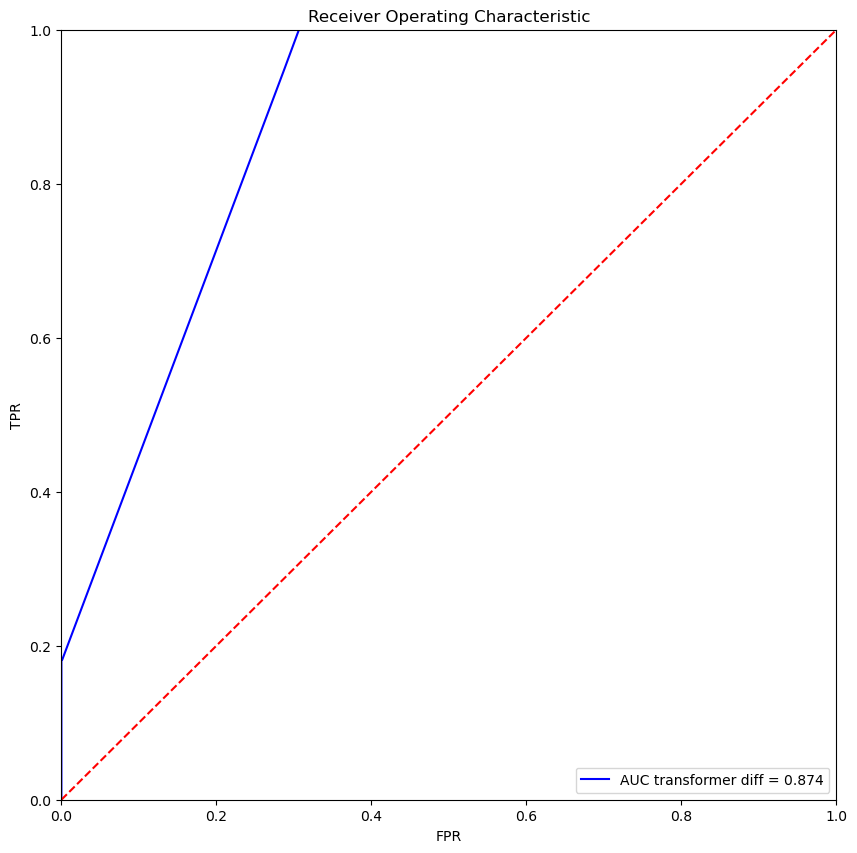

In [65]:
roc_fig_plot(
    [y_test],
    transformer_diff=reconstruction_errors_dos_df["reconstruction_errors"],
)